# Feature Selection für Umsatzvorhersage

Dieses Notebook implementiert eine Feature-Selektion für die Umsatzvorhersage. Es verwendet das adjustierte R² als Metrik, um die beste Kombination von Features zu finden.

## Übersicht
1. Bibliotheken importieren
2. Feature Selector Klasse
3. Feature Selection durchführen
4. Ergebnisse visualisieren

## 1. Bibliotheken importieren

In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import sys
import os
from itertools import combinations

# Add the DataPreparation directory to the Python path
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
data_prep_path = os.path.join(project_root, '0_DataPreparation')
sys.path.append(data_prep_path)
from data_preparation import DataPreparation

## 2. Feature Selector Klasse

Diese Klasse implementiert die Feature-Selektion mit folgenden Hauptfunktionen:
- Berechnung des adjustierten R²
- Evaluierung von Feature-Kombinationen
- Suche nach der besten Feature-Kombination

In [4]:
class FeatureSelector:
    def __init__(self):
        self.data_prep = DataPreparation()
        self.best_features = None
        self.best_model = None
        self.best_adj_r2 = -float('inf')
        
    def adjusted_r2(self, r2, n, p):
        """
        Berechnet das adjustierte R².
        n: Anzahl der Beobachtungen
        p: Anzahl der Features
        """
        return 1 - (1 - r2) * (n - 1) / (n - p - 1)
    
    def evaluate_feature_combination(self, X, y, feature_cols):
        """
        Evaluiert eine Kombination von Features.
        """
        X_subset = X[list(feature_cols)]
        model = LinearRegression()
        model.fit(X_subset, y)
        y_pred = model.predict(X_subset)
        r2 = r2_score(y, y_pred)
        adj_r2 = self.adjusted_r2(r2, len(y), len(feature_cols))
        return adj_r2, model
    
    def find_best_features(self, max_features=10, verbose=True):
        """
        Findet die beste Feature-Kombination.
        """
        # Daten laden und vorbereiten
        data = self.data_prep.load_data()
        train_data, _ = self.data_prep.split_data(data)
        X_train, y_train = self.data_prep.prepare_data(train_data, is_training=True)
        
        all_features = X_train.columns.tolist()
        
        print(f"Suche beste Kombination aus maximal {max_features} Features...")
        print(f"Gesamtanzahl Features: {len(all_features)}")
        
        # Teste verschiedene Feature-Kombinationen
        for n_features in range(1, max_features + 1):
            if verbose:
                print(f"\nTeste Kombinationen mit {n_features} Features...")
            
            for feature_combo in combinations(all_features, n_features):
                adj_r2, model = self.evaluate_feature_combination(X_train, y_train, feature_combo)
                
                if adj_r2 > self.best_adj_r2:
                    self.best_adj_r2 = adj_r2
                    self.best_features = feature_combo
                    self.best_model = model
                    
                    if verbose:
                        print(f"Neue beste Kombination gefunden!")
                        print(f"Features: {feature_combo}")
                        print(f"Adj. R²: {adj_r2:.4f}")
        
        # Finale Ausgabe
        print("\nBeste Feature-Kombination gefunden:")
        print("Features:", self.best_features)
        print(f"Adjustiertes R²: {self.best_adj_r2:.4f}")
        
        # Modellgleichung erstellen
        coef_dict = dict(zip(self.best_features, self.best_model.coef_))
        intercept = self.best_model.intercept_
        
        print("\nLineare Modellgleichung:")
        equation = f"Umsatz = {intercept:.2f}"
        for feature, coef in coef_dict.items():
            equation += f" + ({coef:.2f} × {feature})"
        print(equation)
        
        return self.best_features, self.best_model, self.best_adj_r2

## 3. Feature Selection durchführen

Jetzt führen wir die Feature-Selektion durch und suchen nach der besten Kombination von Features.

In [5]:
# Feature Selector initialisieren
selector = FeatureSelector()

# Beste Features finden (maximal 5 Features)
best_features, best_model, best_adj_r2 = selector.find_best_features(max_features=5)

Trainingsdaten: von 2013-07-01 00:00:00 bis 2017-07-31 00:00:00
Testdaten: von 2017-08-01 00:00:00 bis 2018-07-31 00:00:00
Anzahl Trainingssamples: 7493
Anzahl Testsamples: 1841
Suche beste Kombination aus maximal 5 Features...
Gesamtanzahl Features: 29

Teste Kombinationen mit 1 Features...
Neue beste Kombination gefunden!
Features: ('Jahr',)
Adj. R²: 0.0093
Neue beste Kombination gefunden!
Features: ('Wochentag',)
Adj. R²: 0.0180
Neue beste Kombination gefunden!
Features: ('ist_Wochenende',)
Adj. R²: 0.0256
Neue beste Kombination gefunden!
Features: ('Temperatur',)
Adj. R²: 0.0467
Neue beste Kombination gefunden!
Features: ('Jahreszeit_summer',)
Adj. R²: 0.0487
Neue beste Kombination gefunden!
Features: ('Warengruppe_1',)
Adj. R²: 0.0859
Neue beste Kombination gefunden!
Features: ('Warengruppe_2',)
Adj. R²: 0.4496

Teste Kombinationen mit 2 Features...
Neue beste Kombination gefunden!
Features: ('Jahr', 'Warengruppe_2')
Adj. R²: 0.4596
Neue beste Kombination gefunden!
Features: ('Woc

## 4. Ergebnisse visualisieren

Zum Schluss visualisieren wir die Wichtigkeit der ausgewählten Features.

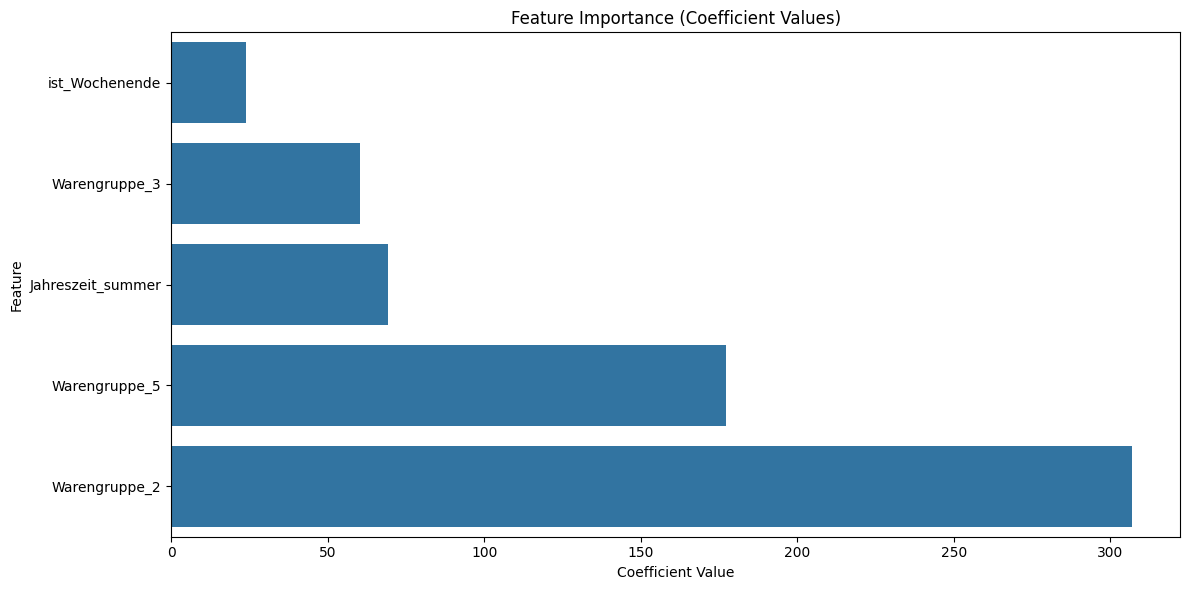

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Importance Plot
plt.figure(figsize=(12, 6))
feature_importance = pd.DataFrame({
    'Feature': list(best_features),
    'Coefficient': best_model.coef_
})

# Sortiere nach absolutem Wert der Koeffizienten
feature_importance['Abs_Coefficient'] = abs(feature_importance['Coefficient'])
feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=True)

# Plot erstellen
sns.barplot(data=feature_importance, x='Coefficient', y='Feature')
plt.title('Feature Importance (Coefficient Values)')
plt.xlabel('Coefficient Value')
plt.tight_layout()
plt.show()